In [242]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

textwidth = 6.
mpl.rcParams['axes.labelsize'] = 11.
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['font.family'] = 'Open Sans'

In [288]:
N = 500

n_samples = 150

cf_w = .1
cf_w_in = 1.

sigm_w_e = .3

eps_a = 10e-2
eps_b = 10e-2

eps_mu = 10e-4
eps_var = 10e-3

mu_y_target = -np.ones((N))*0.

#r_target = .9

T = int(5e2)
T_skip_rec = 1
T_rec = int(T/T_skip_rec)

t_arr = np.arange(T_rec)*T_skip_rec

In [289]:
### recording
a_rec = np.ones((n_samples,T_rec,N))
b_rec = np.ones((T_rec,N))

y_rec = np.ones((T_rec,N))
y_norm_rec = np.ones((n_samples,T_rec))
X_r_rec = np.ones((T_rec,N))
X_e_rec = np.ones((T_rec,N))

mu_y_rec = np.ones((T_rec,N))
mu_X_e_rec = np.ones((T_rec,N))
Var_y_rec = np.ones((T_rec,N))
Var_X_e_rec = np.ones((T_rec,N))
###

for k in tqdm(range(n_samples)):

    W = np.random.normal(0.,1./(cf_w*N)**.5,(N,N)) * (np.random.rand(N,N) <= cf_w)
    W[range(N),range(N)] = 0.

    W = W/np.max(np.abs(np.linalg.eigvals(W)))

    a = np.ones((N))*np.random.rand()*2.5
    b = np.zeros((N))

    if sigm_w_e > 0.:
        w_in = np.random.normal(0.,sigm_w_e,(N,1)) * (np.random.rand(N,1) <= cf_w_in)
    else:
        w_in = np.zeros((N,1))

    u_in = (np.random.rand(1,T) >= .5)*2.-1.

    y = np.ndarray((N))
    X_r = np.ndarray((N))
    X_e = np.ndarray((N))
    #X_e = (w_in @ u_in).T
    #X_e = np.random.normal(0.,1.,(T,N)) * w_in[:,0]
    #X_e = np.random.normal(0.,.25,(T,N))

    mu_y = np.ndarray((N))
    mu_X_e = np.ndarray((N))
    Var_y = np.ndarray((N))
    Var_X_e = np.ndarray((N))



    ### first time step
    X_e[:] = w_in @ u_in[:,0]
    X_r[:] = (np.random.rand(N)-.5)
    X_r[:] *= np.random.rand()*100./np.linalg.norm(X_r)
    y[:] = np.tanh(X_r[:] + X_e[:])
    

    mu_y[:] = y
    mu_X_e[:] = X_e
    Var_y[:] = .25
    Var_X_e[:] = .25

    #### Recording
    a_rec[k,0,:] = a
    b_rec[0,:] = b

    y_rec[0,:] = y
    y_norm_rec[k,0] = np.linalg.norm(y)
    X_r_rec[0,:] = X_r
    X_e_rec[0,:] = X_e

    mu_y_rec[0,:] = mu_y
    mu_X_e_rec[0,:] = mu_X_e
    Var_y_rec[0,:] = Var_y
    Var_X_e_rec[0,:] = Var_X_e
    ####
    ###

    for t in range(1,T):

        X_r[:] = a[:] * (W @ y[:])
        X_e[:] = w_in @ u_in[:,t]

        y[:] = np.tanh(X_r + X_e - b)

        mu_y[:] = (1.-eps_mu)*mu_y + eps_mu * y
        mu_X_e[:] = (1.-eps_mu)*mu_X_e + eps_mu * X_e

        Var_y[:] = (1.-eps_var)*Var_y + eps_var * (y - mu_y)**2.
        Var_X_e[:] = (1.-eps_var)*Var_X_e + eps_var * (X_e - mu_X_e)**2.

        #y_squ_targ = 1.-1./(1.+2.*Var_y.mean() + 2.*Var_X_e)**.5

        a = a + eps_a * a * ((y**2.).mean() - (X_r**2.).mean())
        #a = a + eps_a * ((y**2.) - (X_r**2.))
        b = b + eps_b * (y - mu_y_target)

        a = np.maximum(0.1,a)    

        if t%T_skip_rec == 0:
            t_rec = int(t/T_skip_rec)

            #### Recording
            a_rec[k,t_rec,:] = a
            b_rec[t_rec,:] = b

            y_rec[t_rec,:] = y
            X_r_rec[t_rec,:] = X_r
            X_e_rec[t_rec,:] = X_e

            mu_y_rec[t_rec,:] = mu_y
            mu_X_e_rec[t_rec,:] = mu_X_e
            Var_y_rec[t_rec,:] = Var_y
            Var_X_e_rec[t_rec,:] = Var_X_e
            ####
    y_norm_rec[k,:] = np.linalg.norm(y_rec,axis=1)

In [290]:
sigm_w = 1.

a = np.linspace(0.,2.5,500)
vy = np.linspace(0.,1.*N,500)

A,VY = np.meshgrid(a,vy)

delta_a = eps_a*A*(1.-sigm_w**2.*A**2.)*VY/N

delta_vy = np.zeros((500,500))

for k in tqdm(range(1000)):

    delta_vy += N*(1-(1. + 2*sigm_w**2.*A**2.*VY/N + 2.*np.random.normal(0.,sigm_w_e)**2.)**(-.5))-VY

delta_vy /= 1000.

<IPython.core.display.Javascript object>


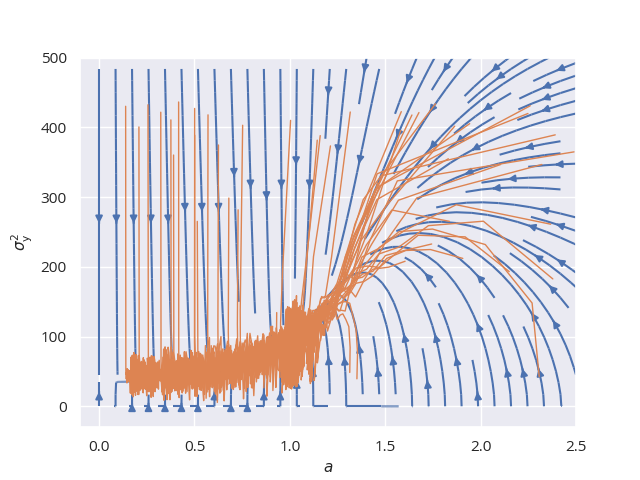

In [291]:
fig, ax = plt.subplots(1,1)

ax.streamplot(A,VY,delta_a,delta_vy)

vy_pl = np.linspace(0.,1.*N,1000)
a_pl = np.linspace(0.,2.5,1000)



#ax.plot((((1.-vy_pl/N)**(-2.)/2. - v_e - .5 )/(sigm_w**2.*vy_pl/N))**.5,vy_pl)
#ax.plot(0.*a + sigm_w**(-1.),vy)

for k in range(50):
    plt.plot(a_rec[k,:,0],y_norm_rec[k,:]**2.,c=colors[1],alpha=1.,lw=1)
    #plt.plot(a_rec[k,1:,0])
    #plt.plot(y_norm_rec[k,1:])


ax.set_xlim([a_pl[0]-.1,a_pl[-1]])
ax.set_ylim([vy_pl[0]-30.,vy_pl[-1]])

ax.set_xlabel('$a$')
ax.set_ylabel('$\\sigma_{\\rm y}^2$')


plt.show()

<IPython.core.display.Javascript object>


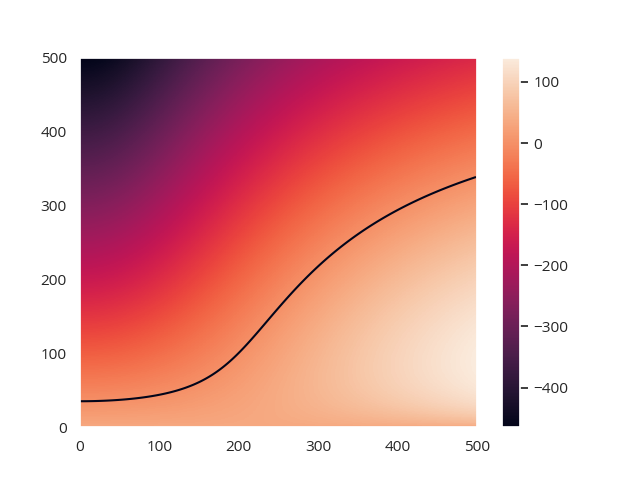

In [292]:
plt.figure()
plt.pcolormesh(delta_vy)
plt.colorbar()
plt.contour(delta_vy,levels=[0.])
plt.show()